# КУРСОВОЙ ПРОЕКТ 
### ПО КУРСУ "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"
Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

Метрика оценки - Коэффициент детерминации:
\[R^2=1−\frac{σ^2}{σ^2_y}\]
https://en.wikipedia.org/wiki/Coefficient_of_determination

File descriptions
train.csv - the training set
test.csv - the test set
sampleSubmission.csv - a sample submission file in the correct format


Data fields:
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image
from datetime import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# Пути к директориям и файлам
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
#PREPARED_DATASET_PATH = 'housing_prepared.csv'

#REPORTS_FILE_PATH = './reports/'
#SCALER_FILE_PATH = './models/scaler.pkl'
#PMODEL_FILE_PATH = './models/model.pkl'


In [4]:
# ГРАФИКИ
def df_num_features_hist(dfx):
    df_num_features = dfx.select_dtypes(include=['float64', 'float32', 'float16','int64'])
    df_num_features.hist(figsize=(16,16), bins=20, grid=False);

# как переменные коррелируют с ценой продажи
def saleprice_corr_heat_map(dfh):
    fig, ax = plt.subplots(figsize=(14,10))
    saleprice_corr = dfh.corr()[['Price']].sort_values(
      by='Price', ascending=False)
    sns.heatmap(saleprice_corr, annot=True, ax=ax) 

Загрузка датасета

In [5]:
df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [6]:
df['Ecology_1'].value_counts()

0.007122    587
0.000000    537
0.243205    511
0.072158    486
0.075779    346
           ... 
0.386772      6
0.011320      3
0.394094      2
0.012522      1
0.014334      1
Name: Ecology_1, Length: 129, dtype: int64

In [7]:
df.shape

(10000, 20)

In [8]:
df['Id'] = df['Id'].astype(str)
df['DistrictId'] = df['DistrictId'].astype(str)

In [9]:
df.dtypes

Id                object
DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
#что из себя представляют данные
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01
Social_2,10000.0,5352.157400,4006.799803,168.000000,1564.000000,5285.000000,7227.000000,1.908300e+04


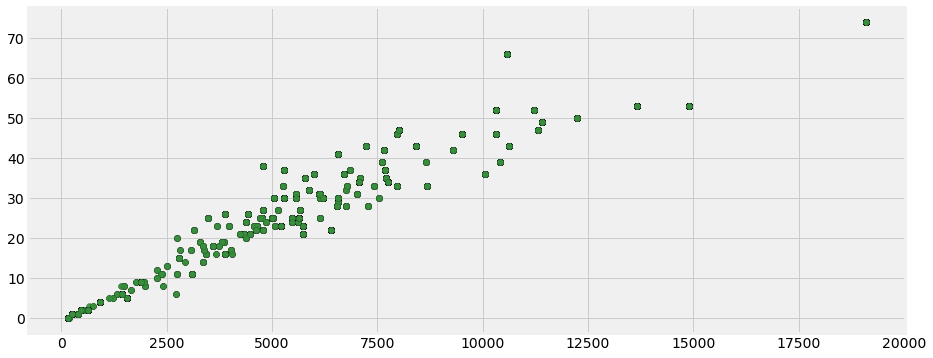

In [11]:
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(x=df['Social_2'], y=df['Social_1'], color="#388e3c", 
           edgecolors="#000000", linewidths=0.1, alpha=0.7);
plt.show()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [13]:
# определяем концентрацию пропусков в каждом столбце
df.isnull().mean() * 100

Id                0.00
DistrictId        0.00
Rooms             0.00
Square            0.00
LifeSquare       21.13
KitchenSquare     0.00
Floor             0.00
HouseFloor        0.00
HouseYear         0.00
Ecology_1         0.00
Ecology_2         0.00
Ecology_3         0.00
Social_1          0.00
Social_2          0.00
Social_3          0.00
Healthcare_1     47.98
Helthcare_2       0.00
Shops_1           0.00
Shops_2           0.00
Price             0.00
dtype: float64

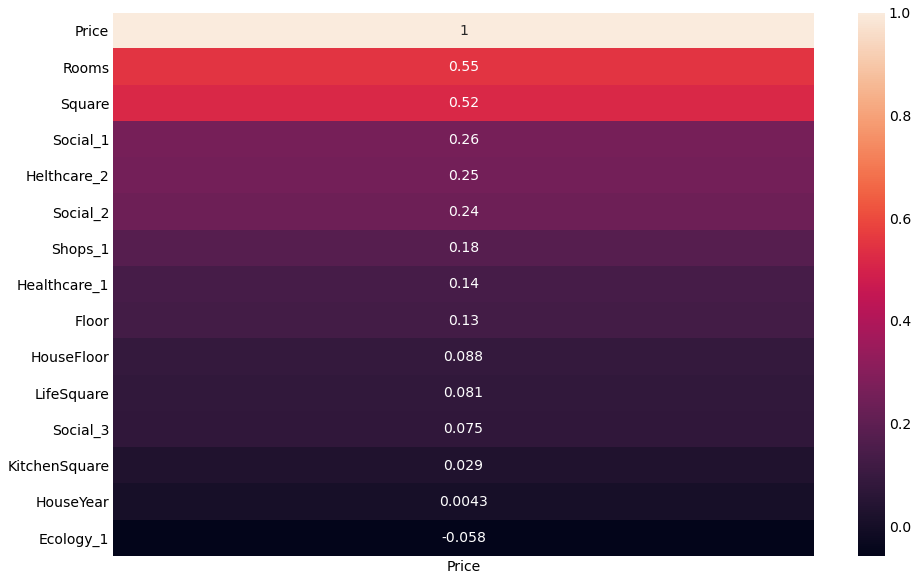

In [14]:
saleprice_corr_heat_map(df)

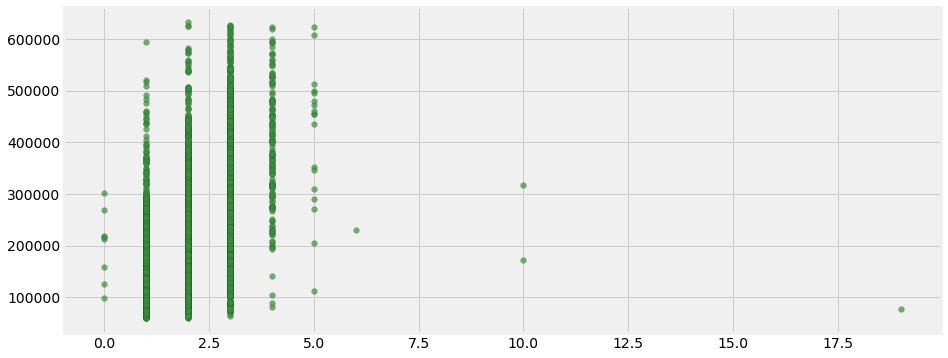

In [15]:
# резулрующая точечная диаграмма
fig, ax = plt.subplots(figsize=(14,6))
ax.scatter(x=df['Rooms'], y=df['Price'], color="#388e3c", 
           edgecolors="#000000", linewidths=0.1, alpha=0.7);
plt.show()

## Подготовка данных

### Rooms

In [16]:
# проверка на уникальные данные
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [17]:
# убираем нули и ограничиваем максимум 6
df['Rooms_outlier'] = 0
df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
df.head()
df.loc[df['Rooms'] == 0, 'Rooms'] = 1
df.loc[df['Rooms'] >= 6, 'Rooms'] = df['Rooms'].median()

In [18]:
df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

### KitchenSquare

In [19]:
df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

In [20]:
df['KitchenSquare_outlier'] = 0
df.loc[(df['KitchenSquare'] == 0),'KitchenSquare_outlier']= 1
df.loc[df['KitchenSquare'] == 0, 'KitchenSquare'] = 1

### Floor & HouseFloor

In [21]:
df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [22]:
df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [23]:
(df['Floor'] > df['HouseFloor']).sum()

1825

In [24]:
df['HouseFloor_outlier'] = 0
df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1

df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()

floor_outliers =df.loc[df['Floor'] > df['HouseFloor']].index
print(floor_outliers)

df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

print((df['Floor'] > df['HouseFloor']).sum())

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)
0


In [25]:
df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

## DistrictId

In [26]:
df['DistrictId'].value_counts()        

27     851
1      652
23     565
6      511
9      294
      ... 
174      1
117      1
205      1
199      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [27]:
#замена вещественного на количественное на количество случаев
district_size = df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [28]:
# присоединение к действующему датасету
df = df.merge(district_size, on='DistrictId', how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,0,NaN,0,0,B,305018.871089,0,0,0,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,1183.0,1,0,B,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,240.0,3,1,B,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,0,NaN,0,1,B,168106.007630,0,0,0,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,2,NaN,0,6,B,343995.102962,0,0,0,89


In [29]:
# ценовая интрепретация района и колва комнат в районе
med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [30]:
med_price_by_district.shape

(667, 3)

In [31]:
#присоединение к действующему датасету
df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize,MedPriceByDistrict
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,NaN,0,0,B,305018.871089,0,0,0,851,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,B,177734.553407,0,0,0,78,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,B,282078.720850,0,0,0,652,244005.272380
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,NaN,0,1,B,168106.007630,0,0,0,652,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,NaN,0,6,B,343995.102962,0,0,0,89,201584.441255


In [32]:
# замена некорреткных данных на медиану
current_year = datetime.now().year
df['HouseYear_outlier'] = 0
df.loc[(df['HouseYear'] >= current_year), 'HouseYear_outlier']= 1
df.loc[df['HouseYear'] >= current_year, 'HouseYear'] = df['HouseYear'].median()

In [33]:
df.isna().sum()

Id                          0
DistrictId                  0
Rooms                       0
Square                      0
LifeSquare               2113
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
KitchenSquare_outlier       0
HouseFloor_outlier          0
DistrictSize                0
MedPriceByDistrict          0
HouseYear_outlier           0
dtype: int64

не все данные есть по столбцу LifeSquare и Healthcare_1
проведем графический анализ данных по этим столбцам и выберем по какой системе заполнить пропущенные данные
LifeSquare по медиане и Healthcare_1 по средней

In [34]:
df['LifeSquare_nan'] = 0
df['Healthcare_1_nan'] = 0
df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize,MedPriceByDistrict,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014.0,0.075424,...,B,305018.871089,0,0,0,851,213530.788443,0,1,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966.0,0.118537,...,B,177734.553407,0,0,0,78,146032.829834,0,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988.0,0.025609,...,B,282078.720850,0,0,0,652,244005.272380,0,0,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977.0,0.007122,...,B,168106.007630,0,0,0,652,146735.671740,0,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972.0,0.282798,...,B,343995.102962,0,0,0,89,201584.441255,0,0,1


In [35]:
df.isna().sum()

Id                          0
DistrictId                  0
Rooms                       0
Square                      0
LifeSquare               2113
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
KitchenSquare_outlier       0
HouseFloor_outlier          0
DistrictSize                0
MedPriceByDistrict          0
HouseYear_outlier           0
LifeSquare_nan              0
Healthcare_1_nan            0
dtype: int64

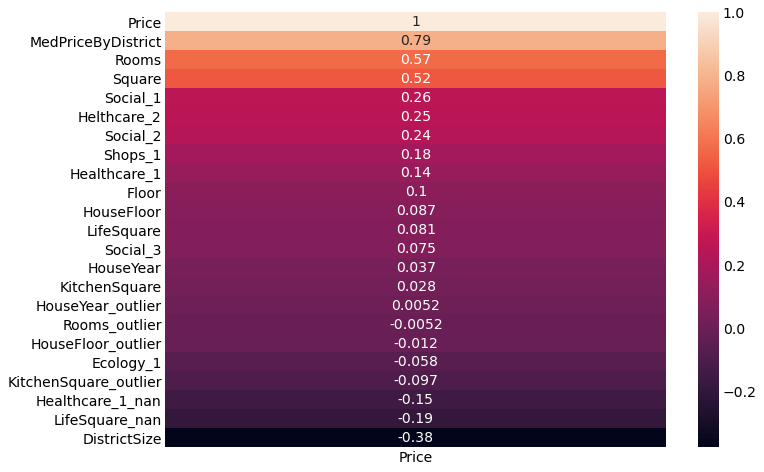

In [36]:
# как переменные коррелируют с ценой продажи
fig, ax = plt.subplots(figsize=(10,8))
saleprice_corr = df.corr()[['Price']].sort_values(
  by='Price', ascending=False)
sns.heatmap(saleprice_corr, annot=True, ax=ax) 

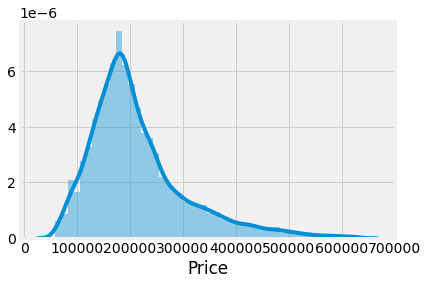

In [37]:
sns.distplot(df['Price']);

In [38]:
df[(df['LifeSquare_nan'] == 1) & (df['Healthcare_1_nan'] == 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize,MedPriceByDistrict,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014.0,0.075424,...,B,305018.871089,0,0,0,851,213530.788443,0,1,1
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977.0,0.007122,...,B,168106.007630,0,0,0,652,146735.671740,0,1,1
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977.0,0.007122,...,B,128803.593810,0,0,0,652,146735.671740,0,1,1
24,4717,27,1.0,44.203947,NaN,1.0,2,13.0,1977.0,0.072158,...,A,135466.559958,0,1,1,851,118349.682906,0,1,1
30,5931,23,1.0,43.033398,NaN,1.0,3,4.0,1977.0,0.014073,...,B,72659.971575,0,0,0,565,102069.270740,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9968,9920,1,3.0,86.487550,NaN,1.0,7,17.0,1977.0,0.007122,...,B,248248.935528,0,0,1,652,244005.272380,0,1,1
9969,5054,23,2.0,52.723072,NaN,1.0,10,17.0,1977.0,0.034656,...,B,126243.208331,0,0,0,565,142883.014837,0,1,1
9978,4851,1,1.0,39.314342,NaN,1.0,13,17.0,1977.0,0.007122,...,B,137782.941940,0,0,0,652,146735.671740,0,1,1
9981,6753,62,2.0,73.092686,NaN,1.0,4,16.0,2017.0,0.072158,...,A,159077.198056,0,0,0,247,178912.369081,0,1,1


In [39]:
df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'Rooms_outlier',
       'KitchenSquare_outlier', 'HouseFloor_outlier', 'DistrictSize',
       'MedPriceByDistrict', 'HouseYear_outlier', 'LifeSquare_nan',
       'Healthcare_1_nan'],
      dtype='object')

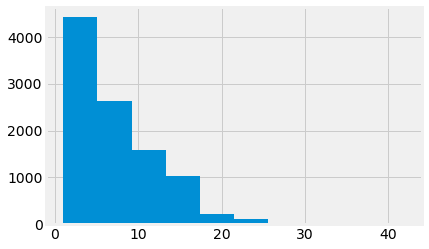

In [40]:
df['Floor'].hist();

In [41]:
df.drop("Id", axis=1, inplace = True)
df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Price', 'Rooms_outlier', 'KitchenSquare_outlier',
       'HouseFloor_outlier', 'DistrictSize', 'MedPriceByDistrict',
       'HouseYear_outlier', 'LifeSquare_nan', 'Healthcare_1_nan'],
      dtype='object')

In [42]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [43]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [44]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [45]:
def insert_int (col):
    df.loc[df[col] == 'B', col] = 2
    df.loc[df[col] == 'A', col] = 1
    df[col] = df[col].astype(np.int64)
    print (f"{df[col].value_counts()}")
    
insert_int('Ecology_2')
insert_int('Shops_2')
insert_int('Ecology_3')

2    9903
1      97
Name: Ecology_2, dtype: int64
2    9175
1     825
Name: Shops_2, dtype: int64
2    9725
1     275
Name: Ecology_3, dtype: int64


### ценовая интрепретация Shops 1 и 2 

In [46]:
ShopsPrice = df.groupby(['Shops_1', 'Shops_2'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'ShopsPrice'})

ShopsPrice.head()

,Shops_1,Shops_2,ShopsPrice
0,0,1,165135.381758
1,0,2,160686.389789
2,1,2,188768.311817
3,2,2,182814.218401
4,3,2,221502.349414


In [47]:
med_price_by_district.shape

(667, 3)

In [48]:
#присоединение к действующему датасету
df = df.merge(ShopsPrice, on=['Shops_1', 'Shops_2'], how='left')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Price,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize,MedPriceByDistrict,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,ShopsPrice
0,27,3.0,115.027311,NaN,10.0,4,10.0,2014.0,0.075424,2,...,305018.871089,0,0,0,851,213530.788443,0,1,1,160686.389789
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966.0,0.118537,2,...,177734.553407,0,0,0,78,146032.829834,0,0,0,160686.389789
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988.0,0.025609,2,...,282078.720850,0,0,0,652,244005.272380,0,0,0,188768.311817
3,1,1.0,40.409907,NaN,1.0,10,22.0,1977.0,0.007122,2,...,168106.007630,0,0,0,652,146735.671740,0,1,1,188768.311817
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972.0,0.282798,2,...,343995.102962,0,0,0,89,201584.441255,0,0,1,219003.735652


### ценовая интрепретация Ecology 1 и 2 

In [49]:
df['Ecology_23'] = 0
df.loc[(df['Ecology_2'] == 0) & (df['Ecology_3'] == 0), 'Ecology_23'] = 1
df.loc[(df['Ecology_2'] == 1) & (df['Ecology_3'] == 0), 'Ecology_23'] = 2
df.loc[(df['Ecology_2'] == 0) & (df['Ecology_3'] == 1), 'Ecology_23'] = 3
df.loc[(df['Ecology_2'] == 1) & (df['Ecology_3'] == 1), 'Ecology_23'] = 4
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Rooms_outlier,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize,MedPriceByDistrict,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,ShopsPrice,Ecology_23
0,27,3.0,115.027311,NaN,10.0,4,10.0,2014.0,0.075424,2,...,0,0,0,851,213530.788443,0,1,1,160686.389789,0
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966.0,0.118537,2,...,0,0,0,78,146032.829834,0,0,0,160686.389789,0
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988.0,0.025609,2,...,0,0,0,652,244005.272380,0,0,0,188768.311817,0
3,1,1.0,40.409907,NaN,1.0,10,22.0,1977.0,0.007122,2,...,0,0,0,652,146735.671740,0,1,1,188768.311817,0
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972.0,0.282798,2,...,0,0,0,89,201584.441255,0,0,1,219003.735652,0


In [50]:
# ценовая интрепретация Ecology 1 и 2 
EcologyPrice = df.groupby(['Ecology_1', 'Ecology_23'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'EcologyPrice'})

EcologyPrice.head()

,Ecology_1,Ecology_23,EcologyPrice
0,0.000000e+00,0,239973.726358
1,1.800000e-09,0,343589.405088
2,6.998930e-05,0,205321.620544
3,7.815280e-05,0,167082.631131
4,1.696760e-04,0,207122.123132


In [51]:
#присоединение к действующему датасету
df = df.merge(EcologyPrice, on=['Ecology_1', 'Ecology_23'], how='left')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,KitchenSquare_outlier,HouseFloor_outlier,DistrictSize,MedPriceByDistrict,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,ShopsPrice,Ecology_23,EcologyPrice
0,27,3.0,115.027311,NaN,10.0,4,10.0,2014.0,0.075424,2,...,0,0,851,213530.788443,0,1,1,160686.389789,0,148315.419074
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966.0,0.118537,2,...,0,0,78,146032.829834,0,0,0,160686.389789,0,186809.604691
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988.0,0.025609,2,...,0,0,652,244005.272380,0,0,0,188768.311817,0,205993.377137
3,1,1.0,40.409907,NaN,1.0,10,22.0,1977.0,0.007122,2,...,0,0,652,146735.671740,0,1,1,188768.311817,0,183882.806975
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972.0,0.282798,2,...,0,0,89,201584.441255,0,0,1,219003.735652,0,203153.518639


### Поиск выбросов

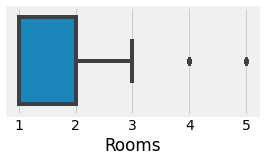

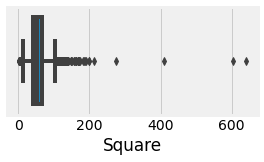

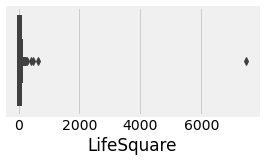

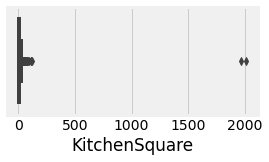

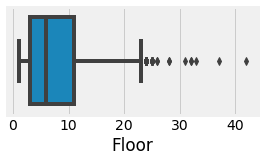

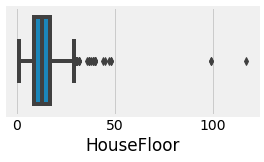

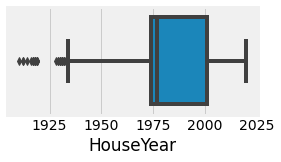

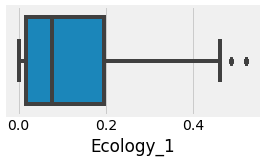

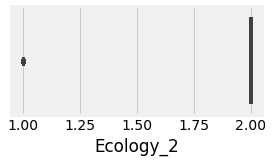

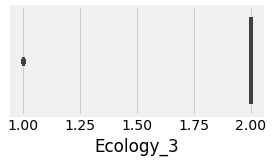

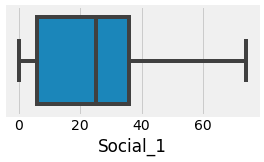

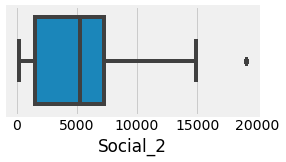

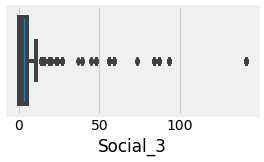

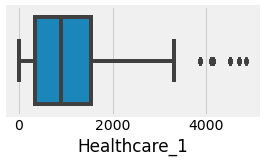

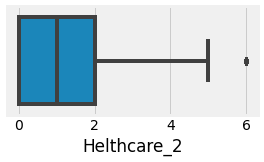

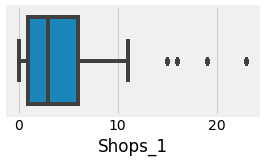

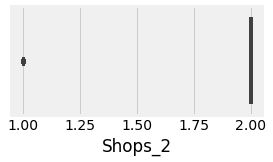

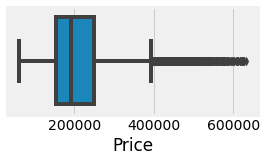

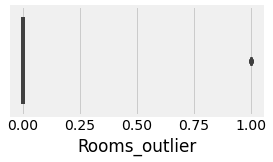

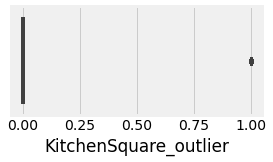

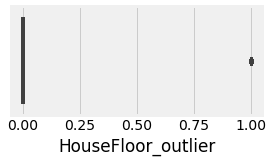

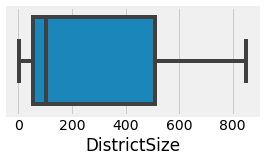

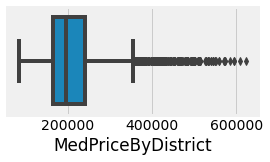

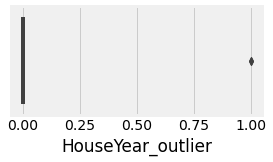

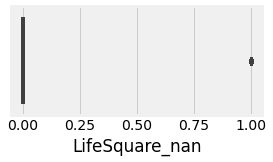

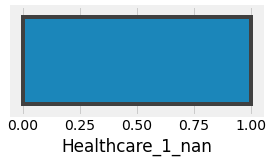

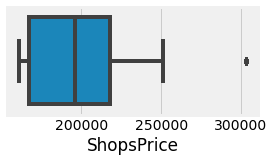

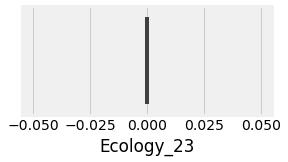

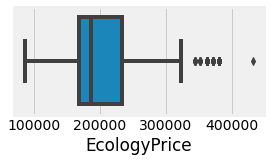

In [52]:
def boxplot_plt(col):
    plt.figure(figsize=(4, 2))
    sns.boxplot(df[col], whis=1.5)
    plt.xlabel(col)
    plt.show()

for col_i in df.drop(columns='DistrictId').columns:
    boxplot_plt(col_i)

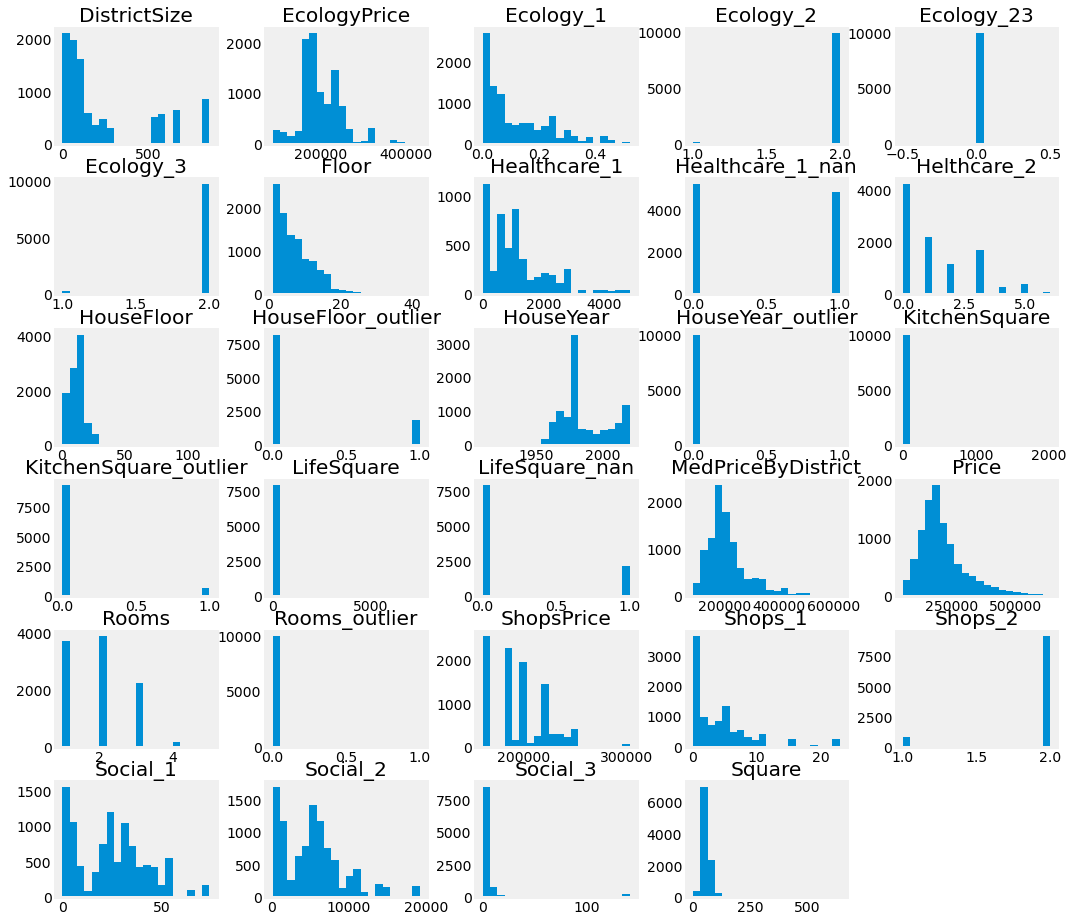

In [53]:
df_num_features_hist(df)

In [54]:
median = df['LifeSquare'].median()
df['LifeSquare'].fillna(median, inplace=True)


In [55]:
#поиск выбросов по квантилю 0.975
def quant (col):
    quant975 = np.quantile(df[col], q=0.975)
    df.loc[df[col] > quant975, col] = df[col].median()
    return quant975

print(F"Rooms =  {quant('Rooms')}")
print(F"Square =  {quant('Square')}")
print(F"LifeSquare =  {quant('LifeSquare')}")
print(F"KitchenSquare =  {quant('KitchenSquare')}")
print(F"Floor =  {quant('Floor')}")
print(F"HouseFloor =  {quant('HouseFloor')}")
print(F"Social_3 =  {quant('Social_3')}")
print(F"Healthcare_1 =  {quant('Healthcare_1')}")

Rooms =  3.0
Square =  100.90624548226137
LifeSquare =  78.3859441855343
KitchenSquare =  13.0
Floor =  19.0
HouseFloor =  25.0
Social_3 =  93.0
Healthcare_1 =  nan


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DistrictId             10000 non-null  object 
 1   Rooms                  10000 non-null  float64
 2   Square                 10000 non-null  float64
 3   LifeSquare             10000 non-null  float64
 4   KitchenSquare          10000 non-null  float64
 5   Floor                  10000 non-null  float64
 6   HouseFloor             10000 non-null  float64
 7   HouseYear              10000 non-null  float64
 8   Ecology_1              10000 non-null  float64
 9   Ecology_2              10000 non-null  int64  
 10  Ecology_3              10000 non-null  int64  
 11  Social_1               10000 non-null  int64  
 12  Social_2               10000 non-null  int64  
 13  Social_3               10000 non-null  float64
 14  Healthcare_1           5202 non-null   float64
 15  Hel

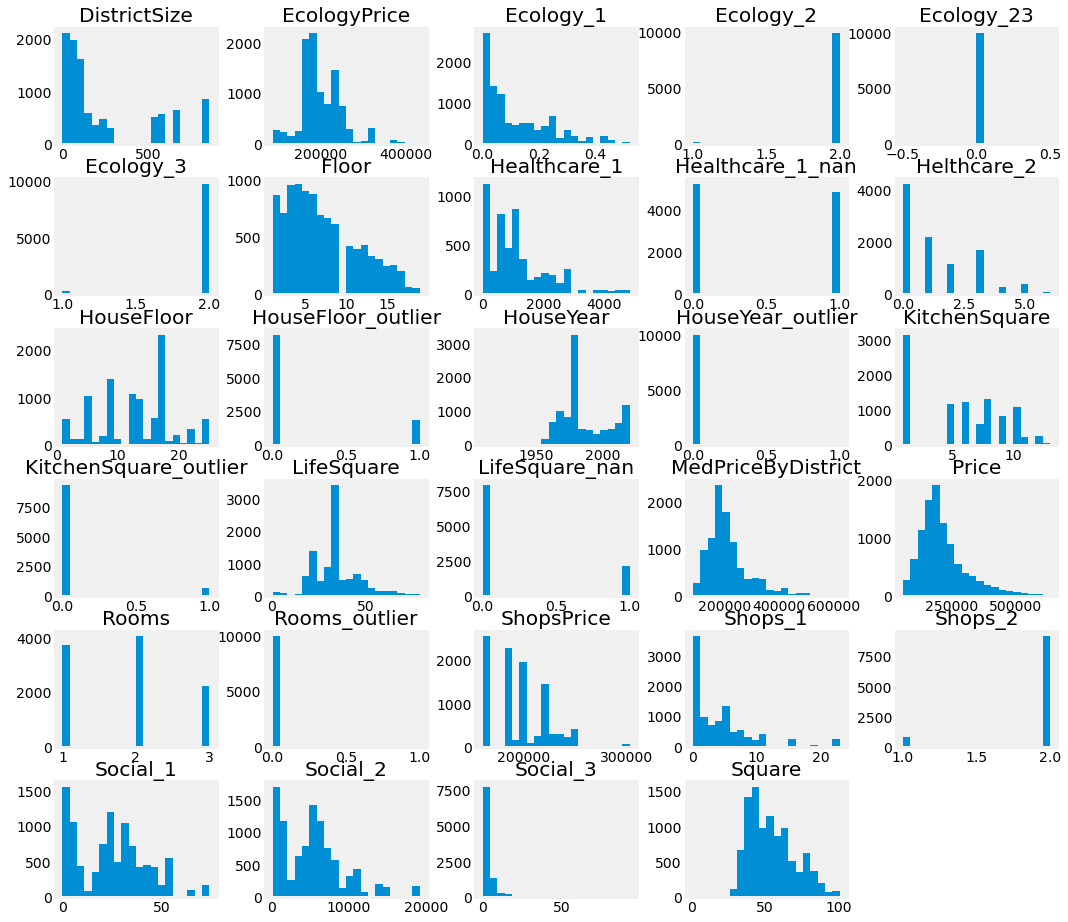

In [57]:
df_num_features_hist(df)

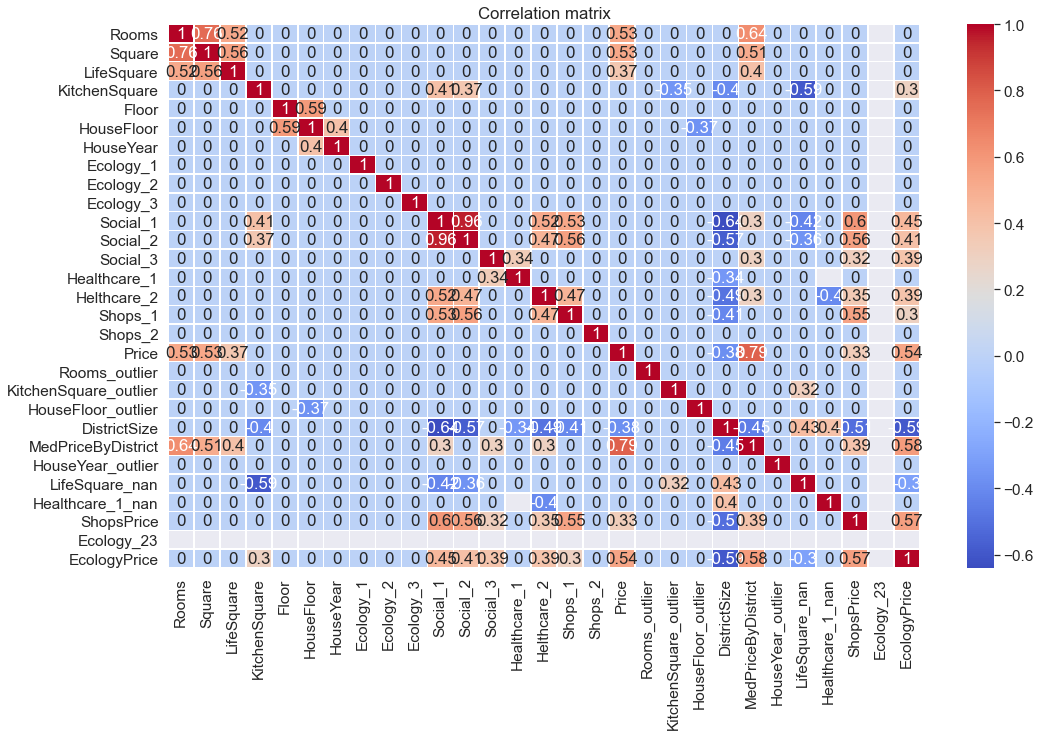

In [58]:
# Матрица корреляций
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Создание новых признаков
* 1) LifeSquare / Square чем выше тем дороже
* 2) LifeSquare / Room чем  выше тем дороже
* 3) HouseYear - признак нового (до 5 лет), среднего (от 5 до 25 лет) и старого дома (больше 25 лет)
* 4) Зависимость Shops от цены
* 5) Зависимость Ecology от цены

In [59]:
df['LifeSquare_Square'] = df['LifeSquare']/df['Square']
df['Rooms_LifeSquare'] = df['LifeSquare']/df['Rooms']
df['HouseYear_group'] = 0
df.loc[2021 - df['HouseYear'] <= 5, 'HouseYear_group'] = 0
df.loc[(2021 - df['HouseYear'] > 5) & (2021 - df['HouseYear'] <= 25), 'HouseYear_group'] = 1
df.loc[2021 - df['HouseYear'] > 25, 'HouseYear_group'] = 2
df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,MedPriceByDistrict,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,ShopsPrice,Ecology_23,EcologyPrice,LifeSquare_Square,Rooms_LifeSquare,HouseYear_group
0,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014.0,0.075424,2,...,213530.788443,0,1,1,160686.389789,0,148315.419074,0.624247,10.927087,1
1,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,2,...,146032.829834,0,0,0,160686.389789,0,186809.604691,0.581666,23.169223,2
2,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,2,...,244005.272380,0,0,0,188768.311817,0,205993.377137,0.608509,15.890657,2
3,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977.0,0.007122,2,...,146735.671740,0,1,1,188768.311817,0,183882.806975,0.811218,32.781260,2
4,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,2,...,201584.441255,0,0,1,219003.735652,0,203153.518639,0.599867,19.281258,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,2.0,49.090728,33.272626,6.0,3.0,12.0,1981.0,0.300323,2,...,232514.855623,0,0,1,218046.583330,0,223982.521830,0.677778,16.636313,2
9996,27,2.0,64.307684,37.038420,9.0,13.0,13.0,1977.0,0.072158,2,...,165683.084779,0,0,1,165135.381758,0,165691.439110,0.575956,18.519210,2
9997,178,1.0,29.648057,16.555363,5.0,3.0,5.0,1958.0,0.460556,2,...,165953.912580,0,0,1,197513.930234,0,244852.013738,0.558396,16.555363,2
9998,21,1.0,32.330292,22.326870,5.0,3.0,9.0,1969.0,0.194489,2,...,153921.400690,0,0,0,197513.930234,0,182897.300817,0.690587,22.326870,2


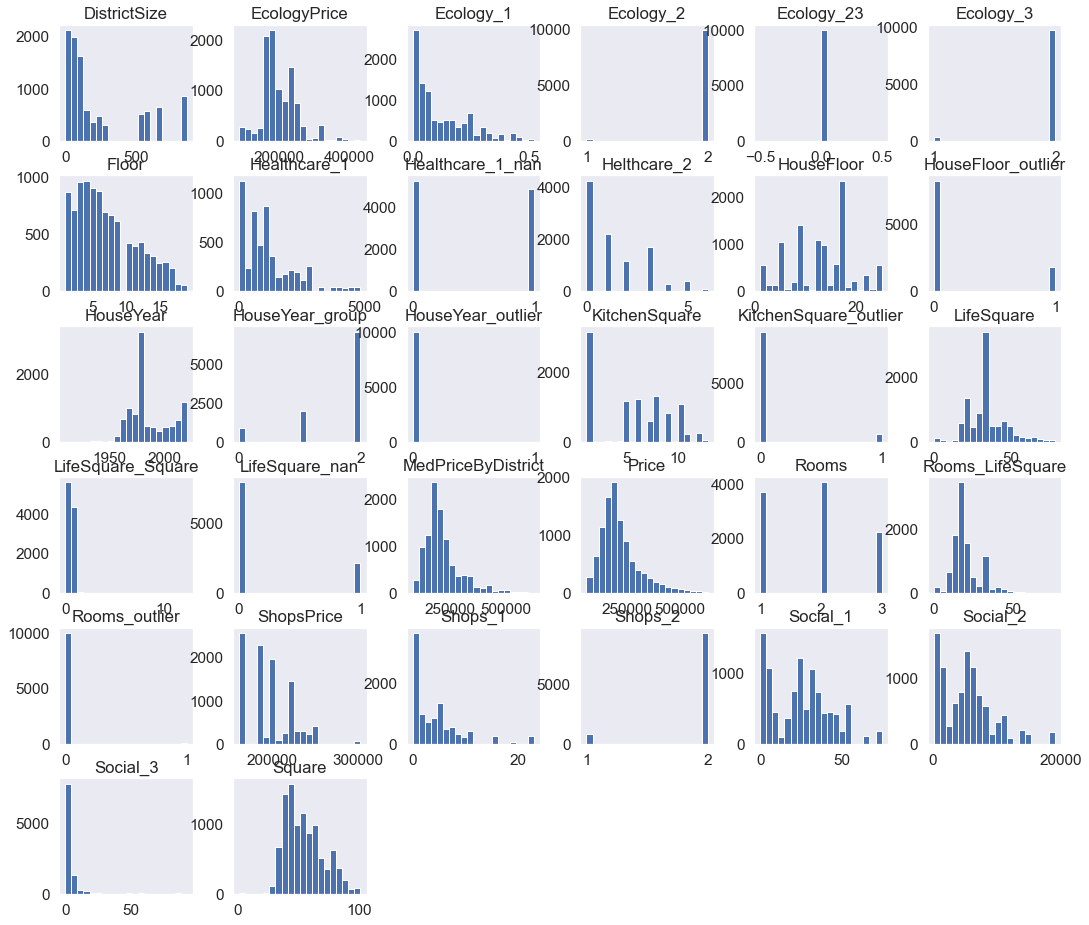

In [60]:
df_num_features_hist(df)

In [61]:
drop_col = ["Healthcare_1"]
df.drop(drop_col, axis=1, inplace = True)
df.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'Price', 'Rooms_outlier', 'KitchenSquare_outlier', 'HouseFloor_outlier',
       'DistrictSize', 'MedPriceByDistrict', 'HouseYear_outlier',
       'LifeSquare_nan', 'Healthcare_1_nan', 'ShopsPrice', 'Ecology_23',
       'EcologyPrice', 'LifeSquare_Square', 'Rooms_LifeSquare',
       'HouseYear_group'],
      dtype='object')

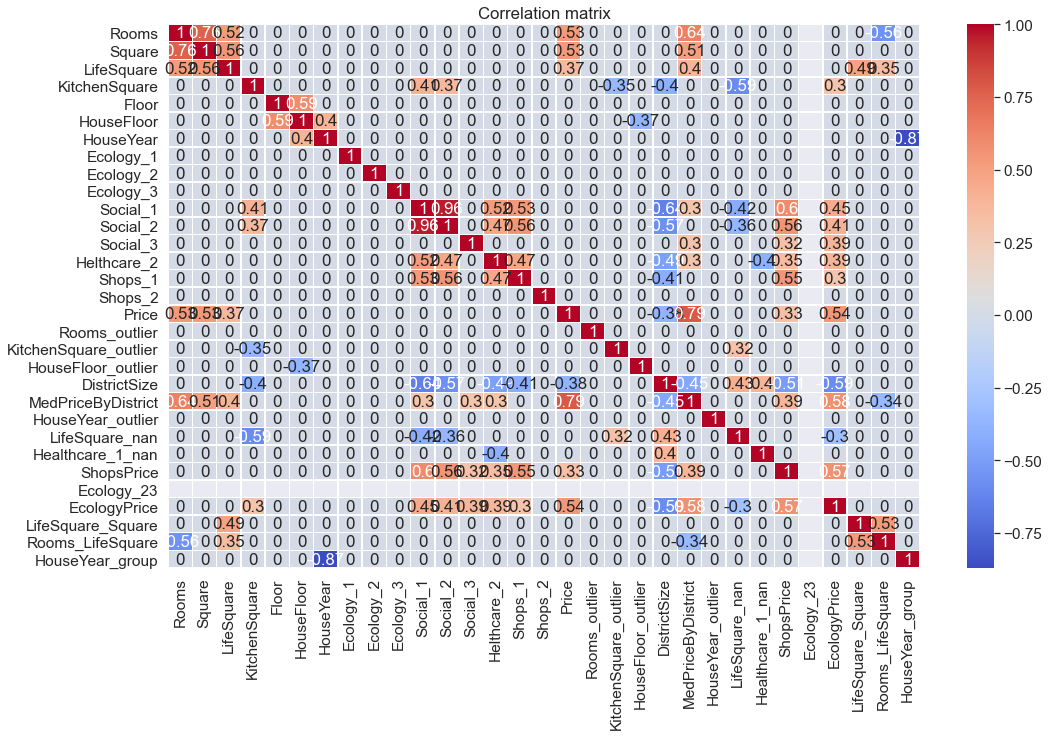

In [62]:
# Матрица корреляций
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [63]:
#df.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8')
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,MedPriceByDistrict,HouseYear_outlier,LifeSquare_nan,Healthcare_1_nan,ShopsPrice,Ecology_23,EcologyPrice,LifeSquare_Square,Rooms_LifeSquare,HouseYear_group
0,27,3.0,52.513310,32.781260,10.0,4.0,10.0,2014.0,0.075424,2,...,213530.788443,0,1,1,160686.389789,0,148315.419074,0.624247,10.927087,1
1,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966.0,0.118537,2,...,146032.829834,0,0,0,160686.389789,0,186809.604691,0.581666,23.169223,2
2,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988.0,0.025609,2,...,244005.272380,0,0,0,188768.311817,0,205993.377137,0.608509,15.890657,2
3,1,1.0,40.409907,32.781260,1.0,10.0,22.0,1977.0,0.007122,2,...,146735.671740,0,1,1,188768.311817,0,183882.806975,0.811218,32.781260,2
4,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972.0,0.282798,2,...,201584.441255,0,0,1,219003.735652,0,203153.518639,0.599867,19.281258,2


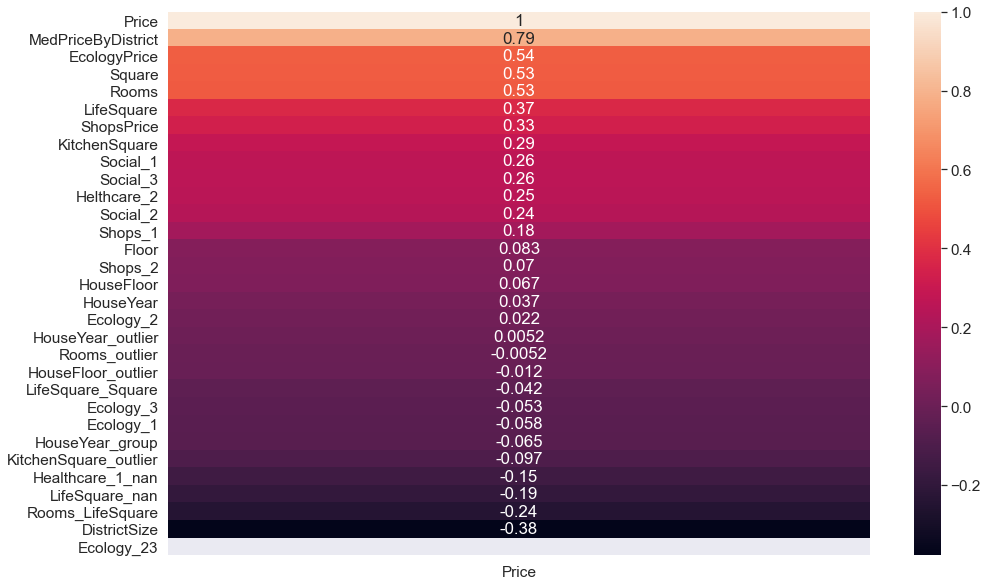

In [64]:
saleprice_corr_heat_map(df)

Классы обрабоки данных и добавления новых фичей

In [65]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.quant_975 = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.X = X
    
    @staticmethod
    def quant975(col, X):
        quant_975 = X[col].quantile(.975)
        X.loc[X[col] > quant_975, col] = X[col].median()
        return quant_975
   
    @staticmethod
    def insertint(col, X):
        X.loc[X[col] == 'B', col] = 2
        X.loc[X[col] == 'A', col] = 1
        X[col] = X[col].astype(np.int64)
       
    
   
    def transform(self, X):
        """Трансформация данных"""
        #quantile 975
        self.quant975('Rooms', X)
        self.quant975('Square', X)
        self.quant975('LifeSquare', X)
        self.quant975('KitchenSquare', X)
        self.quant975('Floor', X)
        self.quant975('HouseFloor', X)
        self.quant975('Social_3', X)
        self.quant975('Healthcare_1', X)
        
        #замена А и В на 1 и 2 
        self.insertint('Ecology_2', X)
        self.insertint('Shops_2', X)
        self.insertint('Ecology_3', X)

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        X['HouseYear_group'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        X.loc[current_year - X['HouseYear'] <= 5, 'HouseYear_group'] = 1
        X.loc[(current_year - X['HouseYear'] > 5) & (current_year - X['HouseYear'] <= 10), 'HouseYear_group'] = 2
        X.loc[(current_year - X['HouseYear'] > 10) & (current_year - X['HouseYear'] <= 15), 'HouseYear_group'] = 3
        X.loc[(current_year - X['HouseYear'] > 15) & (current_year - X['HouseYear'] <= 20), 'HouseYear_group'] = 4
        X.loc[(current_year - X['HouseYear'] > 20) & (current_year - X['HouseYear'] <= 25), 'HouseYear_group'] = 5
        X.loc[(current_year - X['HouseYear'] > 25) & (current_year - X['HouseYear'] <= 30), 'HouseYear_group'] = 6
        X.loc[(current_year - X['HouseYear'] > 30) & (current_year - X['HouseYear'] <= 35), 'HouseYear_group'] = 7
        X.loc[current_year - X['HouseYear'] > 35, 'HouseYear_group'] = 8
        
             
        
        # Ecology_2, 3
        X['Ecology_23'] = 0
        X.loc[(X['Ecology_2'] == 0) & (X['Ecology_3'] == 0), 'Ecology_23'] = 1
        X.loc[(X['Ecology_2'] == 1) & (X['Ecology_3'] == 0), 'Ecology_23'] = 2
        X.loc[(X['Ecology_2'] == 0) & (X['Ecology_3'] == 1), 'Ecology_23'] = 3
        X.loc[(X['Ecology_2'] == 1) & (X['Ecology_3'] == 1), 'Ecology_23'] = 4
        X.head()
        
        
        if 'Id' in X.columns:
            X.drop('Id', axis=1, inplace=True)
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
               
        X.fillna(self.medians, inplace=True)
        
        return X

In [66]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.ShopsPrice_median = None
        self.EcologyPrice_median = None
        self.ShopsPrice = None
        self.EcologyPrice = None
        self.Square_HouseYearPrice = None
        self.Square_HouseYearPrice_median = None
        
    def fit(self, X, y=None):
        
              
        X = X.copy()
           
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms, Shops, Ecology
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
            self.ShopsPrice = df.groupby(['Shops_1', 'Shops_2'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'ShopsPrice'})
            self.ShopsPrice_median = self.ShopsPrice['ShopsPrice'].median()
            
            self.EcologyPrice = df.groupby(['Ecology_1', 'Ecology_23'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'EcologyPrice'})
            self.EcologyPrice_median = self.EcologyPrice['EcologyPrice'].median()
            
        
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
                        

        
    def transform(self, X):
        
        X['LifeSquare_Square'] = X['LifeSquare'] / X['Square']
        X['Rooms_LifeSquare'] = X['LifeSquare'] / X['Rooms']       
        
       #замена А и В на 1 и 2 
        self.insertint('Ecology_2', X)
        self.insertint('Shops_2', X)
        self.insertint('Ecology_3', X)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
                
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
        
        if self.ShopsPrice is not None:
            X = X.merge(self.ShopsPrice, on=['Shops_1', 'Shops_2'], how='left')
            X['ShopsPrice'].fillna(self.ShopsPrice_median, inplace=True)
            
        if self.EcologyPrice is not None:
            X = X.merge(self.EcologyPrice, on=['Ecology_1', 'Ecology_23'], how='left')
            X['EcologyPrice'].fillna(self.EcologyPrice_median, inplace=True)
            
           
        return X
    
    @staticmethod
    def quant975(col, X):
        quant_975 = X[col].quantile(.975)
        X.loc[X[col] > quant_975, col] = X[col].median()
        return quant_975
   
    @staticmethod
    def insertint(col, X):
        X.loc[X[col] == 'B', col] = 2
        X.loc[X[col] == 'A', col] = 1
        X[col] = X[col].astype(np.int64)
   

### Разбиение на train / test 

In [67]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)
target_name='Price'
X = train_df.drop(columns=target_name)
y = train_df[target_name]



In [68]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)

In [69]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)

X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6000, 21), (4000, 21), (5000, 21))

In [70]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6000, 29), (4000, 29), (5000, 29))

In [71]:
X_train.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'HouseYear_group',
 'Ecology_23',
 'LifeSquare_Square',
 'Rooms_LifeSquare',
 'DistrictSize',
 'new_district',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'ShopsPrice',
 'EcologyPrice']

In [72]:
feature_names_for_stand = [
 'Rooms',
 'LifeSquare', 
 'KitchenSquare',
 'Square', 
 'Floor',
 'HouseFloor',
 'Social_3', 
 'DistrictSize', 
 'LifeSquare_Square',
 'Rooms_LifeSquare',
 'HouseYear_group', 
 'ShopsPrice',
 'EcologyPrice'
]
# 'MedPriceByDistrict',
# 'Square_HouseYearPrice'

In [73]:
X_train = X_train[feature_names_for_stand]
X_valid = X_valid[feature_names_for_stand]
test_df = test_df[feature_names_for_stand]

In [74]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Линейная регрессия

In [75]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.593
RMSE:	58386.549
MSE:	3408989107.861


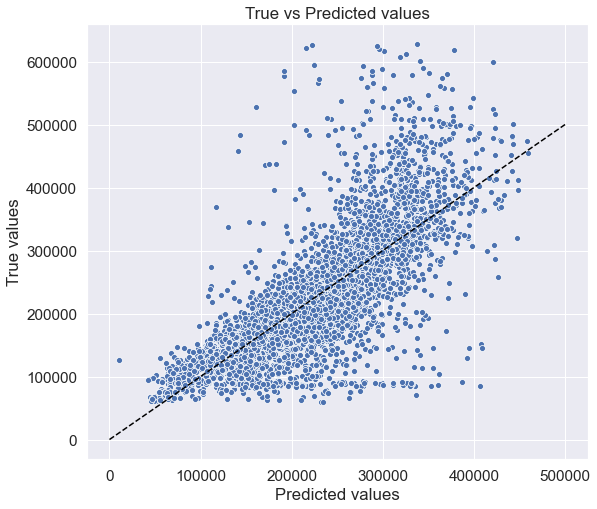

In [76]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

R2:	0.542
RMSE:	64143.706
MSE:	4114415011.885


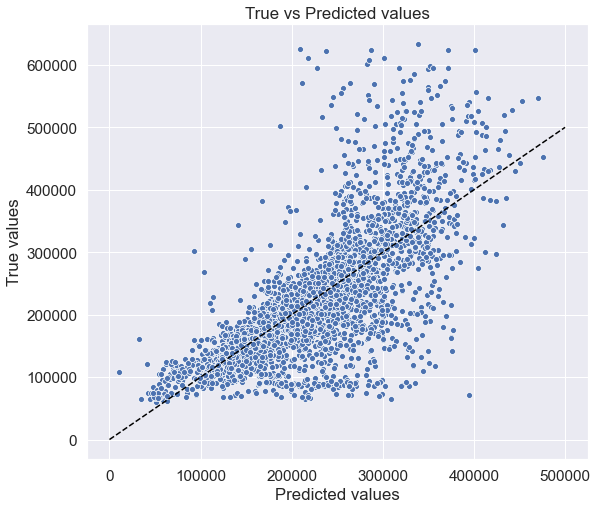

In [77]:
y_test_preds = lr_model.predict(X_valid)
# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500000)

evaluate_preds(y_valid, y_test_preds)

### Decision tree

R2:	0.754
RMSE:	45384.852
MSE:	2059784785.411


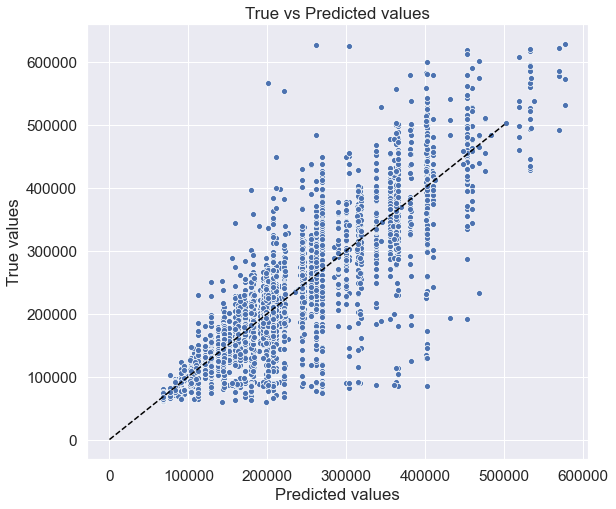

In [78]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=7, # глубина дерева  
                                 min_samples_leaf=1, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.573
RMSE:	61941.919
MSE:	3836801297.957


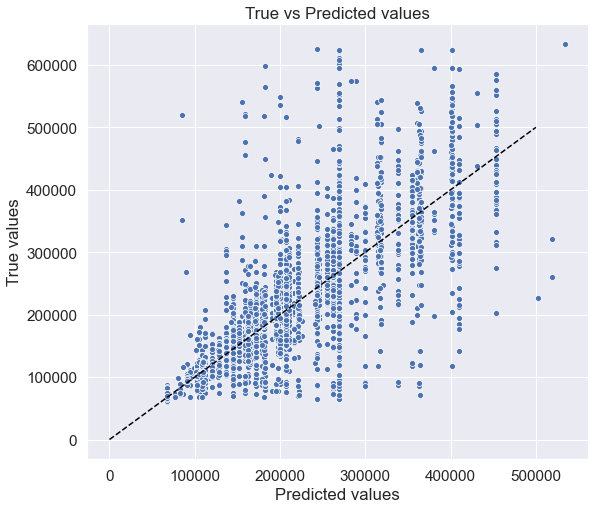

In [79]:
y_test_preds = dt_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

### Random Forest

R2:	0.751
RMSE:	45687.051
MSE:	2087306644.139


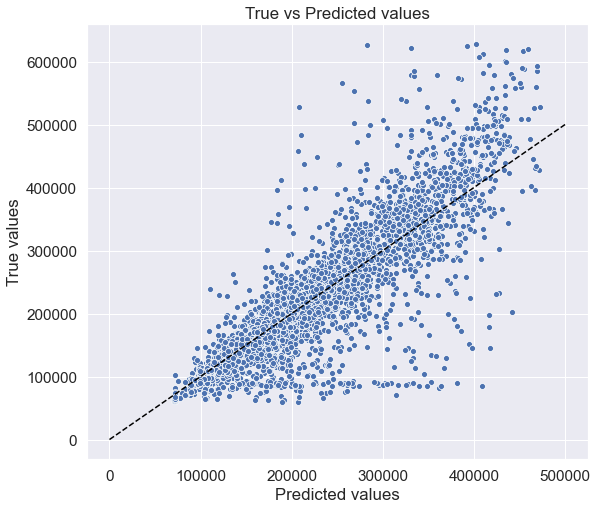

In [80]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=10, # глубина дерева  
                                 min_samples_leaf=20, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=50  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)    

R2:	0.638
RMSE:	57038.046
MSE:	3253338679.052


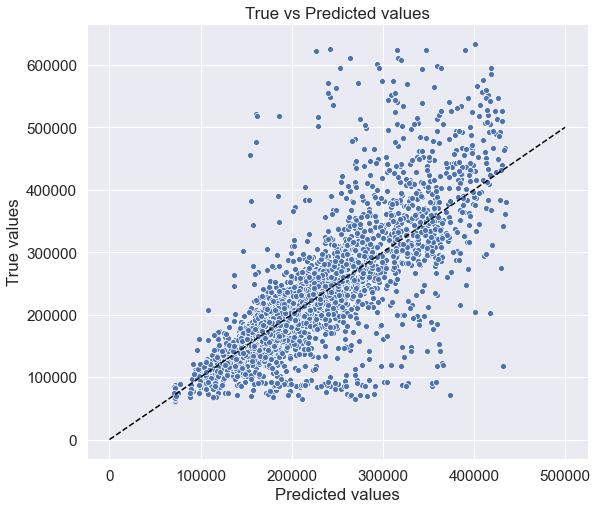

In [81]:
y_test_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

### Gradient Boosting decision trees

R2:	0.869
RMSE:	33144.319
MSE:	1098545915.015


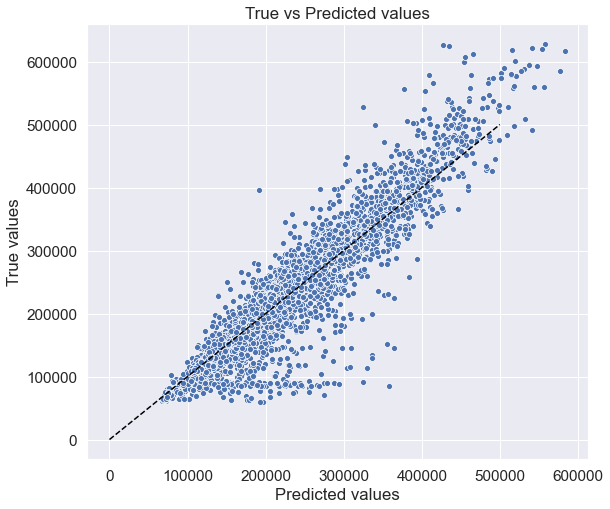

In [82]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=50)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.66
RMSE:	55233.538
MSE:	3050743671.973


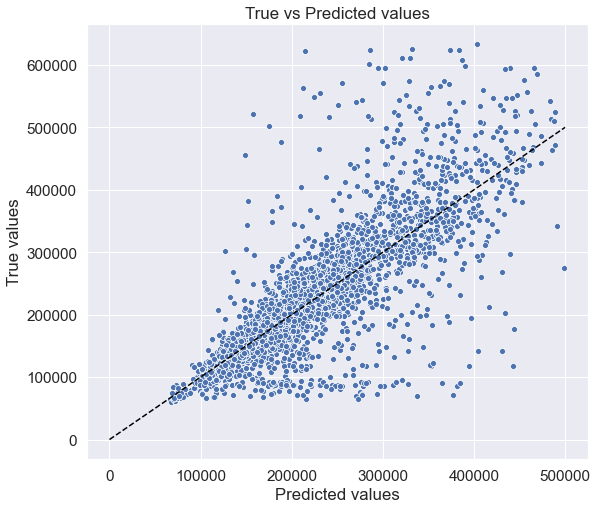

In [83]:
y_test_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

### Кросс валидация и подбор гиперпараметров

In [84]:
%%time
params = {'n_estimators':[50, 75, 100, 150], 
          'max_depth':[3, 5, 10, 15]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

Wall time: 42.3 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse', max_depth=7,
                                                 min_samples_leaf=10,
                                                 n_estimators=50,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15],
                         'n_estimators': [50, 75, 100, 150]},
             scoring='r2')

In [85]:
res = pd.DataFrame(gs.cv_results_)
res.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.760,0.013267,0.0066,0.000799,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.684479,0.690222,0.679898,0.654176,0.715012,0.684757,0.019515,16
1,1.143,0.011765,0.0070,0.000633,3,75,"{'max_depth': 3, 'n_estimators': 75}",0.704967,0.702322,0.698572,0.667149,0.735491,0.701700,0.021709,15


In [86]:
gs.best_params_

{'max_depth': 5, 'n_estimators': 150}

In [87]:
gs.best_score_

0.7313332913956012

### Обучение и оценка модели

In [88]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=20,
                                        random_state=42,
                                        n_estimators=150)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=20,
                          n_estimators=150, random_state=42)

R2:	0.85
RMSE:	35494.08
MSE:	1259829726.492


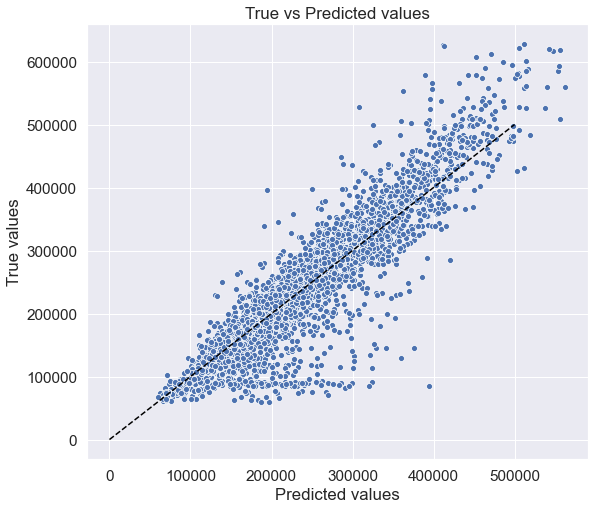

In [89]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.668
RMSE:	54642.102
MSE:	2985759360.973


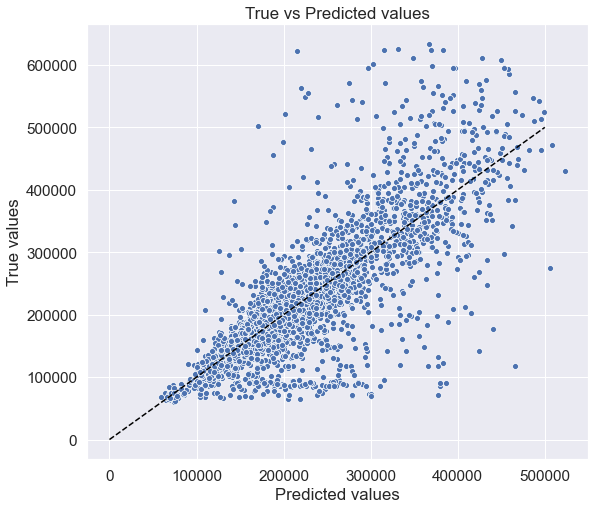

In [90]:
y_test_preds = final_model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)


### Анализ прогнозов

In [91]:
final_model.feature_importances_

array([0.01657504, 0.01173949, 0.01332214, 0.4002331 , 0.00483957,
       0.01829072, 0.03647955, 0.11496039, 0.02617465, 0.01458222,
       0.01737197, 0.00973506, 0.3156961 ])

In [92]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [93]:
# лучшие фичи
feature_importances.head(3)

,feature_name,importance
3,Square,0.400233
12,EcologyPrice,0.315696
7,DistrictSize,0.114960


In [94]:
# худшие фичи
feature_importances.tail(3)

,feature_name,importance
1,LifeSquare,0.011739
11,ShopsPrice,0.009735
4,Floor,0.004840


In [95]:
feature_importances.head

<bound method NDFrame.head of          feature_name  importance
3              Square    0.400233
12       EcologyPrice    0.315696
7        DistrictSize    0.114960
6            Social_3    0.036480
8   LifeSquare_Square    0.026175
5          HouseFloor    0.018291
10    HouseYear_group    0.017372
0               Rooms    0.016575
9    Rooms_LifeSquare    0.014582
2       KitchenSquare    0.013322
1          LifeSquare    0.011739
11         ShopsPrice    0.009735
4               Floor    0.004840>

### Прогнозирование на тестовом датасете

In [96]:
test_df.shape

(5000, 13)

In [97]:
test_df

,Rooms,LifeSquare,KitchenSquare,Square,Floor,HouseFloor,Social_3,DistrictSize,LifeSquare_Square,Rooms_LifeSquare,HouseYear_group,ShopsPrice,EcologyPrice
0,1.0,19.094182,5.0,36.847630,5.0,9.0,0.0,59.0,0.518193,19.094182,8,186815.333920,202526.486861
1,1.0,42.568133,10.0,42.493907,7.0,17.0,1.0,143.0,1.001747,42.568133,1,166578.543757,167058.274940
2,2.0,32.600139,9.0,59.463678,19.0,19.0,0.0,511.0,0.548236,16.300069,8,186815.333920,117344.434056
3,3.0,33.893825,6.0,49.646030,2.0,2.0,0.0,344.0,0.682710,11.297942,8,158149.809835,135380.827307
4,1.0,32.600139,1.0,53.837056,8.0,17.0,4.0,68.0,0.605533,32.600139,8,225009.784092,181535.387902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,30.339945,5.0,43.177521,3.0,5.0,4.0,52.0,0.702679,15.169972,8,182453.436044,184397.588091
4996,3.0,32.925087,10.0,93.698122,1.0,12.0,2.0,22.0,0.351395,10.975029,1,238835.315617,285605.055008
4997,1.0,19.003259,5.0,33.656723,2.0,5.0,1.0,61.0,0.564620,19.003259,8,197863.708789,197923.742758
4998,1.0,20.976257,9.0,38.635155,8.0,14.0,5.0,30.0,0.542932,20.976257,8,253918.394398,217009.909079


In [103]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [104]:
predictions = final_model.predict(test_df)
predictions

array([163441.436023  , 117116.20273759, 145306.65495802, ...,
       143830.15333214, 195225.41026191, 245968.42684399])

In [105]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,163441.436023
1,5925,117116.202738
2,960,145306.654958
3,3848,140272.754644
4,746,199525.052031


In [106]:
submit.to_csv('final_model_submit.csv', index=False)

In [107]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rooms,10000.0,1.852200,0.756976,1.000000,1.000000,2.000000,2.000000,3.000000
Square,10000.0,54.498131,15.818490,1.136859,41.774881,52.513040,64.591720,100.904263
LifeSquare,10000.0,33.846218,12.346232,0.370619,25.527399,32.781260,39.424685,78.384631
KitchenSquare,10000.0,5.606400,3.573060,1.000000,1.000000,6.000000,8.000000,13.000000
Floor,10000.0,7.058400,4.495532,1.000000,3.000000,6.000000,10.000000,19.000000
HouseFloor,10000.0,12.815400,6.030154,1.000000,9.000000,13.000000,17.000000,25.000000
HouseYear,10000.0,1984.863800,18.409979,1910.000000,1974.000000,1977.000000,2001.000000,2020.000000
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,0.521867
Ecology_2,10000.0,1.990300,0.098015,1.000000,2.000000,2.000000,2.000000,2.000000
Ecology_3,10000.0,1.972500,0.163543,1.000000,2.000000,2.000000,2.000000,2.000000


## Сохранение окружения

In [108]:
import sklearn
print(sklearn.__version__)

0.23.1


In [109]:
pip freeze

alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
argh==0.26.2
asn1crypto==1.3.0
astroid @ file:///C:/ci/astroid_1592487315634/work
astropy==4.0.1.post1
atomicwrites==1.4.0
attrs==19.3.0
autopep8 @ file:///tmp/build/80754af9/autopep8_1592412889138/work
Babel==2.8.0
backcall==0.2.0
backports.functools-lru-cache==1.6.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
bcrypt==3.1.7
beautifulsoup4==4.9.1
bitarray @ file:///C:/ci/bitarray_1594751093906/work
bkcharts==0.2
bleach==3.1.5
bokeh @ file:///C:/ci/bokeh_1593178781838/work
boto==2.49.0
Bottleneck==1.3.2
brotlipy==0.7.0
certifi==2020.6.20
cffi==1.14.0
chardet==3.0.4
click==7.1.2
cloudpickle @ file:///tmp/build/80754af9/cloudpickle_1594141588948/work
clyent==1.2.2
colorama==0.4.3
comtypes==1.1.7
conda==4.8.3
conda-build==3.18.11
conda-package-handling==1.7.0
conda-verify==3.4.2
contextlib2==0.6.0.post1
cryptography==2.9.2
cycler==0.10.0
Cython @ fi